## Macro Economist agent

From the past, many industry practitioners have combined technical indicators and macroeconomic data for better understanding of financial market circumstances and better trading decisions. In this section, I introduce how we can utilize macroeconomic data for trading with the combination of technical indicators and twitter sentiment.

## Setup

### Setup paths

* Add necessary imports for Google Drive which will be the working directory.
* Change the paths according to where your dataset is.

In [ ]:
from google.colab import drive
import sys, os

#mount google drive
drive.mount('/content/drive', force_remount=False)
# Change folder path so it corresponds to your environment
# COLAB_PATH = '/content/drive/My Drive/'
# change directory to the path above
# os.chdir(COLAB_PATH)

Mounted at /content/drive


### Install libraries

Install relevant libraries.

In [ ]:
!pip install pymysql

     |████████████████████████████████| 43 kB 996 kB/s 


### Import libraries

In [ ]:
#libraries for general purpose
import requests
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns
import time
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
import calendar
import warnings
import json
import seaborn as sns
from sqlalchemy import create_engine
warnings.filterwarnings(action='ignore')

In [ ]:
#libraries for macro economic data angent
import pandas_datareader.data as web
from random import choice
import scipy.stats as st
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
%matplotlib inline

### Create sql alchemy engine

It is used to establish the access to the NUS data library. Regarding NUS data library, please ask to Reshma who is the manager of the database. About the details, pls ask to the administrator of data library at Fintech Lab.

In [ ]:
# create sqlalchemy engine
sqlEngine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"
                       .format(user="xxxxxx",
                               pw="xxxxxx",
                               db="xxxxxx",
                               host = 'xxx.xxx.xxx.xxx',
                               port = xxxxx))

## Explanation and guide for Macro Economist Agent

### 1.Macro economic data

I extracted macro economic data from FRED (https://fred.stlouisfed.org/) as follows. While some students tried to find the relationship between cryptocurrency price and minor macro economic data or commodities such as soybeans etc, I chose popular macro and market indices that many industry professionals check market conditions of "risk-on" and "risk-off" sentiment. Following are the data that I gathered and utilized this time.

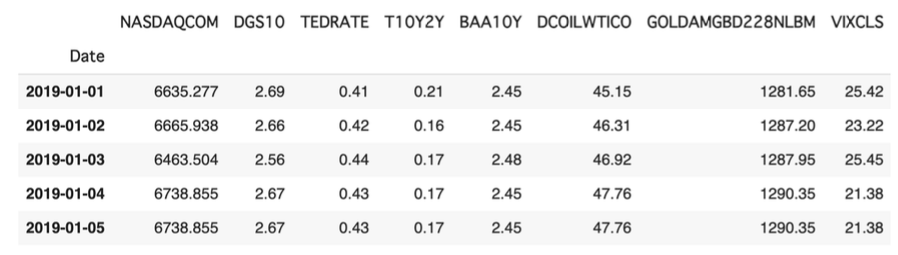

* **'NASDAQCOM'** : NASDAQ Composite Index, which is a major USA technology equity market index.

* **'DGS10'** : 10-Year Treasury Constant Maturity Rate. Interest rate of US government bonds with 10 years of maturity is often referenced as a major reference rate as risk free rate.

* **'TEDRATE'** : TED Spread, the spread between 3-month LIBOR and Treasury bills, which indicates perceived credit risk. LIBOR is the benchmark interest rate of London’s inter-bank lending/borrowing. When credit crunch happens in the financial sector, LIBOR can increase rapidly, compared with the interest of 3 month US Treasury bills.

 (Note: While US dollar LIBOR is disclosed until 2023, it will not be used after that. We need to find an alternative index to check the credit situation in the banking sector.)

* **'T10Y2Y'** : The 10-year minus 2-year Treasury (constant maturity) yields: Positive values may imply future growth, negative values may imply economic downturns. Especially, if this figure becomes negative, it is called “inverse yield”. In many cases, within 2 years after inverse yield, economic downturns and equity market crashes happened in the past.  

* **'BAA10Y'** : Moody's Seasoned Baa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity. It shows the corporate sector’s funding and credit circumstances. In the "risk-on" market, it decreases i.e. companies can easily issue corporate bonds with low interest rates, while in the "risk-off" market, it expands i.e. companies can feel difficulty in funding by issuing corporate bonds even with high interest rates.

* **'DCOILWTICO'** : Crude Oil Prices, West Texas Intermediate (WTI) - Cushing, Oklahoma. It is a major index of oil price. And oil price represents overall commodity price movements and global inflation. When the inflation rate goes up, oil prices tend to go up synthetically. 

* **'GOLDPMGBD228NLBM'** : Gold price. Gold also constitutes an important portion in commodity asset classes. Gold price represents the “value of physical currency”, compared with the US dollar which represents the “value of paper currency”. When the risk of an emergency (such as war) rises, the gold price tends to rise. Also, when people expect high inflation, i.e. the depreciation of paper money’s value, people tend to buy gold such that the gold price tends to rise. 

* **'VIXCLS'** : CBOE Volatility Index: VIX. VIX measures market expectation of near term volatility conveyed by stock index option prices. It shows overall market sentiment of equity market participants. When many market participants expect that the equity market can be stable in the near future, VIX stays at low range. When many market participants expect that the equity market can become unstable in the near future, VIX can go up.

### 2.Data transformation

After gathering the above data, the system does preprocessing and then implements data transformation by Principal Component Analysis (PCA).

* **Data filling:** Macro economic data is usually priced and disclosed on Monday-Friday and holiday is closed i.e., around 250 trading days annually. On the other hand, bitcoin is traded every day i.e. 365 trading days annually. To fit both data comparable, the system converts annual 250 days of trading data into annual 365 days trading data, then executes fillna to fill by previous days data if the macroeconomic data is not available.

* **Rolling % change:** Then, the system calculates 30 days rolling % changes of macroeconomic data, using the function of rollingReturnCalc(preprocessed_df,days=30). The reason for taking 30 days % change and not taking daily % change is that the daily % changes of macroeconomics data is too noisy. By taking 1 month % change of macroeconomic data, the system can capture macroeconomic sentiment in a reasonable manner for practitioners as well.

* **MinMax scalar and PCA:** Next, the system executes PCA by the function of pcaDimReduction(day, macro_pct_df). But before executing PCA, the system implements another data transformation, data normalization of MinMax scalar shown on the formula below. Data normalization intends that normalized values allow the comparison of corresponding normalized values for different datasets in a way that eliminates the effects of certain gross influences.


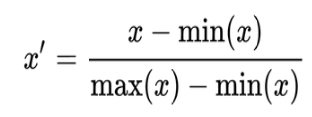

(Source: Wikipedia)

### 3.Principal Component Analysis (PCA) 

* **Principal Component Analysis (PCA)** PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. It is popularly used to reduce the dimensionality of the dataset.

* **Importance of data normalization:** As PCA is interested in the components that maximize the variance, if one component varies less than another because of their respective scales, PCA can work wrongly, such that data normalization is executed beforehand, as mentioned above.


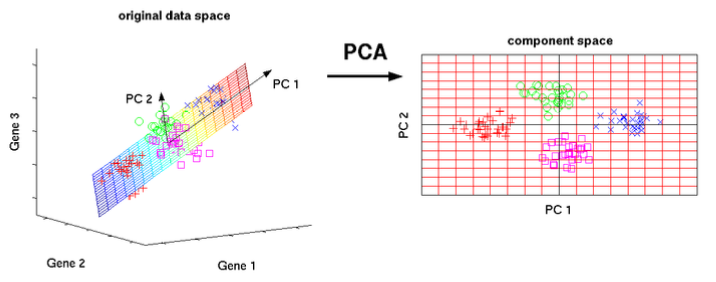

(Source:https://www.analyticsvidhya.com/blog/2016/03/pca-practical-guide-principal-component-analysis-python/)

### Final outcome

 Finally, 8 macroeconomic data can be summarized by 3 factors, shown in the following picture. Macroeconomic agent pass those data to the Decider agent, such that the Decider agent can utilize those macroeconomic data to capture the market circumstance for the day and reflect this insight when the system implements case based reasoning (CBR) as I will explain later.

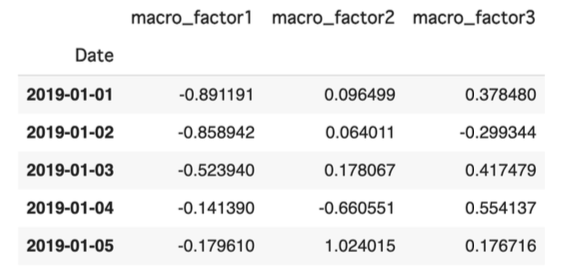

## Whole code of the agent

In [ ]:
class macroEconomist(object):

  @staticmethod
  def dataPreprocessing(macrodata_df):
    #data preprocessing
    startday = macrodata_df.index[0]
    endday =  macrodata_df.index[-1]

    #Change data from 250 trading days per year excluding holidays to 365 days data.
    date_index = pd.date_range(start = startday, end = endday, freq="D").strftime('%Y-%m-%d')
    date_df = pd.DataFrame(date_index)
    date_df.columns = ['Date']
    date_df['Date'] = pd.to_datetime(date_df['Date']) 
    #Add saturday and sunday.
    macrodata_df = macrodata_df.reset_index()
    macrodata_df = date_df.merge(macrodata_df, on='Date', how='outer')
    #change datetype of Date
    macrodata_df['Date'] = macrodata_df['Date'].astype("datetime64")
    #executing ffill (if no price is available, just filling by previous price data)
    macrodata_df = macrodata_df.fillna(method='ffill')
    #set Date as index.
    macrodata_df = macrodata_df.set_index(['Date'])
    macrodata_df = macrodata_df[~macrodata_df.index.duplicated(keep='first')]

    return macrodata_df

  @staticmethod
  def dataAcuisitionFromDataLibrary():
    dbConnection = sqlEngine.connect()
    macro_allhist_df = pd.read_sql("select * from MacroEconomicsData", dbConnection).set_index('Date') 
    dbConnection.close()
    macroEconomist.allhist_preprocessed_df = macroEconomist.dataPreprocessing(macro_allhist_df)

  @staticmethod
  def dataExtraction(startday, endday):
    if startday == endday:
      return macroEconomist.allhist_preprocessed_df.loc[startday,:].to_frame().T
    else:
      return macroEconomist.allhist_preprocessed_df.loc[startday:endday,:]

  @staticmethod
  def rollingReturnCalc(preprocessed_df,days=30):
    #Calculating rolling return of 1 month
    macro_pct_df = preprocessed_df.pct_change(days)
    macro_pct_df = macro_pct_df.replace([np.inf, -np.inf], 0.0)
    #Eliminating rows with nan
    macro_pct_df = macro_pct_df.dropna(thresh=3, axis=0)
    #Datatype handling
    macro_pct_df = macro_pct_df.astype('float')

    return macro_pct_df

  #Dimensionality reduction using PCA.
  @staticmethod
  def pcaDimReduction(day, macro_pct_df):
    #min-max normalization for recent 1 month
    endRow = macro_pct_df.index.get_loc(day) + 1
    startRow = max(0, endRow - 30)
    applied_data_df = macro_pct_df.iloc[startRow:endRow,:]
    #applying min-max normalization
    min_max_scaler = preprocessing.MinMaxScaler()
    normalized_df = pd.DataFrame(min_max_scaler.fit_transform(applied_data_df), 
                                  columns=applied_data_df.columns, index=applied_data_df.index)

    #PCA application
    pca = PCA(n_components=3)
    pca.fit(normalized_df)
    macro_pca = pca.transform(normalized_df)

    macro_pca_df = pd.DataFrame(macro_pca)
    macro_pca_df.columns = ['macro_factor1','macro_factor2','macro_factor3']
    macro_pca_df.index = normalized_df.index
    thisday_pca_df = macro_pca_df.loc[day,:].to_frame().T

    #macroEconomist.hist_pca_df stores 3 macro factors data historically
    macroEconomist.hist_pca_df = pd.concat([macroEconomist.hist_pca_df, thisday_pca_df])
    macroEconomist.hist_pca_df.index.names = ['Date']
    macroEconomist.hist_pca_df = macroEconomist.hist_pca_df[~macroEconomist.hist_pca_df.index.duplicated(keep='first')]

  #initialization of macro data. Obtaining some past data
  @staticmethod
  def dataInitilization(day):
    
    #get whole data from data library
    macroEconomist.dataAcuisitionFromDataLibrary()

    endday = day + datetime.timedelta(days=-1)
    startday = day + datetime.timedelta(days=-60)

    #Get data for recent days
    macro_df = macroEconomist.dataExtraction(startday, endday)
    macro_df.index = macro_df.index.rename('Date')

    #data preprocessing/cleaning
    preprocessed_df = macroEconomist.dataPreprocessing(macro_df)
    macroEconomist.hist_data_df = preprocessed_df
    macroEconomist.hist_pca_df = pd.DataFrame()

  #prepare long-term historical macro economic data
  @staticmethod
  def backtestPrep(startday,endday):
    #get whole data from data library
    macroEconomist.dataAcuisitionFromDataLibrary()

    macro_df = macroEconomist.dataExtraction(startday, endday)
    macro_df.index = macro_df.index.rename('Date')

    #data preprocessing/cleaning
    preprocessed_df = macroEconomist.dataPreprocessing(macro_df)

    
    try:
      macroEconomist.hist_data_df = pd.concat([macroEconomist.hist_data_df,
                                              preprocessed_df])
    except:
      print("please initialize macro data, using macroEconomist.dataInitilization(day)")
    
    macroEconomist.hist_data_df = macroEconomist.hist_data_df[~macroEconomist.hist_data_df.index.duplicated(keep='first')]
    macro_pct_df = macroEconomist.rollingReturnCalc(macroEconomist.hist_data_df)

    day = startday
    while day < endday + datetime.timedelta(days=1):
      macroEconomist.pcaDimReduction(day, macro_pct_df)    
      day = day + datetime.timedelta(days=1)

  #update daily macro economic data
  @staticmethod
  def dailyDataUpdate(day):

    try:
      #Get data
      daily_macro_df = macroEconomist.dataExtraction(day, day)
    except:
      #if data is not available, just return last available day
      daily_macro_df = macroEconomist.allhist_preprocessed_df.loc[:day,:].iloc[-1,:].to_frame().T

    #sometimes no data is returned. In case, just return last available day
    if len(daily_macro_df) == 0:
      daily_macro_df = pd.DataFrame(data=[[np.nan,np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,np.nan]],
                          columns = daily_macro_df.columns)
      daily_macro_df = daily_macro_df.rename(index={0:day})

    daily_macro_df.index = daily_macro_df.index.rename('Date')

    #data preprocessing/cleaning
    #macroEconomist.hist_data_df stores raw macro historical data
    macroEconomist.hist_data_df = pd.concat([macroEconomist.hist_data_df,daily_macro_df])
    macroEconomist.hist_data_df = macroEconomist.dataPreprocessing(macroEconomist.hist_data_df)
    #To avoid error, confirm there is no duplicated index row 
    #by eliminating duplicated index row
    macroEconomist.hist_data_df = macroEconomist.hist_data_df[~macroEconomist.hist_data_df.index.duplicated(keep='first')]

  @staticmethod
  def dailyUpdate(day):
    macroEconomist.dailyDataUpdate(day)
    macro_pct_df = macroEconomist.rollingReturnCalc(macroEconomist.hist_data_df)
    macroEconomist.pcaDimReduction(day, macro_pct_df)

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################
  @staticmethod
  def hist_pca_dfGetter():
    return macroEconomist.hist_pca_df

## Macro Economist agent, step-by-step

### Set up

Reference:


* def dataAcuisitionFromDataLibrary():
* def dataPreprocessing(macrodata_df):
* def dataInitilization(day):
* def backtestPrep(startday,endday):

### Data Acquisition

Reference:
* def dataAcuisitionFromDataLibrary()

In [ ]:
dbConnection = sqlEngine.connect()
macro_allhist_df = pd.read_sql("select * from MacroEconomicsData", dbConnection).set_index('Date') 
dbConnection.close()

In [ ]:
macro_allhist_df.head()

,NASDAQCOM,DGS10,TEDRATE,T10Y2Y,BAA10Y,DCOILWTICO,GOLDAMGBD228NLBM,VIXCLS
Date,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,2308.42,3.85,0.17,2.76,2.54,81.52,1113.00,20.04
2010-01-05,2308.71,3.77,0.18,2.76,2.53,81.74,1125.25,19.35
2010-01-06,2301.09,3.85,0.19,2.84,2.49,83.12,1125.00,19.16
2010-01-07,2300.05,3.85,0.20,2.82,2.48,82.60,1130.75,19.06


### Data preprocessing

Reference:
* def dataPreprocessing(macrodata_df):

In [ ]:
macrodata_df = macro_allhist_df

#data preprocessing
startday = macrodata_df.index[0]
endday =  macrodata_df.index[-1]

#Change data from 250 trading days per year excluding holidays to 365 days data.
date_index = pd.date_range(start = startday, end = endday, freq="D").strftime('%Y-%m-%d')
date_df = pd.DataFrame(date_index)
date_df.columns = ['Date']
date_df['Date'] = pd.to_datetime(date_df['Date']) 
#Add saturday and sunday.
macrodata_df = macrodata_df.reset_index()
macrodata_df = date_df.merge(macrodata_df, on='Date', how='outer')
#change datetype of Date
macrodata_df['Date'] = macrodata_df['Date'].astype("datetime64")
#executing ffill (if no price is available, just filling by previous price data)
macrodata_df = macrodata_df.fillna(method='ffill')
#set Date as index.
macrodata_df = macrodata_df.set_index(['Date'])
macrodata_df = macrodata_df[~macrodata_df.index.duplicated(keep='first')]

allhist_preprocessed_df = macrodata_df

In [ ]:
allhist_preprocessed_df.head()

,NASDAQCOM,DGS10,TEDRATE,T10Y2Y,BAA10Y,DCOILWTICO,GOLDAMGBD228NLBM,VIXCLS
Date,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,2308.42,3.85,0.17,2.76,2.54,81.52,1113.00,20.04
2010-01-05,2308.71,3.77,0.18,2.76,2.53,81.74,1125.25,19.35


### Data initialization for the analysis

Reference:
* def dataInitilization(day):
* def dataExtraction(startday, endday):

In [ ]:
#set up the day for start and end for the analysis
startday = datetime.datetime(2021, 1, 1)
tMinus1day = startday + datetime.timedelta(days=-1)
tMinusYrs = datetime.datetime(2019,1,1)
tMinusYrs_60 = tMinusYrs + datetime.timedelta(days=-60)

In [ ]:
#Get data for recent days
preprocessed_df = allhist_preprocessed_df.loc[tMinusYrs_60:tMinus1day,:]

#set hist_data_df
hist_data_df = preprocessed_df

In [ ]:
hist_data_df.head()

,NASDAQCOM,DGS10,TEDRATE,T10Y2Y,BAA10Y,DCOILWTICO,GOLDAMGBD228NLBM,VIXCLS
Date,,,,,,,,
2018-11-02,7356.996,3.22,0.31,0.31,2.02,63.12,1235.50,19.51
2018-11-03,7356.996,3.22,0.31,0.31,2.02,63.12,1235.50,19.51
2018-11-04,7356.996,3.22,0.31,0.31,2.02,63.12,1235.50,19.51
2018-11-05,7328.852,3.20,0.27,0.29,2.02,63.12,1231.60,19.96
2018-11-06,7375.965,3.22,0.28,0.29,1.98,62.16,1234.85,19.91


### Data transformation: obtain 1 month rolling return of macro data

Reference:
* def rollingReturnCalc(preprocessed_df,days=30):

In [ ]:
def rollingReturnCalc(preprocessed_df,days=30):
  #Calculating rolling return of 1 month
  macro_pct_df = preprocessed_df.pct_change(days)
  macro_pct_df = macro_pct_df.replace([np.inf, -np.inf], 0.0)
  #Eliminating rows with nan
  macro_pct_df = macro_pct_df.dropna(thresh=3, axis=0)
  #Datatype handling
  macro_pct_df = macro_pct_df.astype('float')

  return macro_pct_df

In [ ]:
macro_pct_df = rollingReturnCalc(hist_data_df)

In [ ]:
macro_pct_df

,NASDAQCOM,DGS10,TEDRATE,T10Y2Y,BAA10Y,DCOILWTICO,GOLDAMGBD228NLBM,VIXCLS
Date,,,,,,,,
2018-12-02,-0.003597,-0.065217,0.354839,-0.322581,0.123762,-0.195501,-0.012181,-0.073808
2018-12-03,0.011488,-0.074534,0.322581,-0.516129,0.118812,-0.160646,-0.003602,-0.157355
2018-12-04,-0.026991,-0.096273,0.161290,-0.645161,0.113861,-0.157003,0.003035,0.063045
2018-12-05,-0.023254,-0.090625,0.333333,-0.620690,0.113861,-0.166033,0.003694,0.039078
2018-12-06,-0.025448,-0.108696,0.464286,-0.586207,0.156566,-0.170849,0.001296,0.064289
...,...,...,...,...,...,...,...,...
2020-12-27,0.049065,0.119048,0.071429,0.191176,-0.038793,0.057043,0.035674,0.033109
2020-12-28,0.056823,0.119048,0.071429,0.191176,-0.043103,0.042124,0.035674,0.041267
2020-12-29,0.052792,0.119048,0.071429,0.205882,-0.043103,0.049803,0.036420,0.107486


### Data normalization and executing PCA

In [ ]:
  #Dimensionality reduction using PCA.
  def pcaDimReduction(day, macro_pct_df, hist_pca_df):
    #min-max normalization for recent 1 month
    endRow = macro_pct_df.index.get_loc(day) + 1
    startRow = max(0, endRow - 30)
    applied_data_df = macro_pct_df.iloc[startRow:endRow,:]
    #applying min-max normalization
    min_max_scaler = preprocessing.MinMaxScaler()
    normalized_df = pd.DataFrame(min_max_scaler.fit_transform(applied_data_df), 
                                  columns=applied_data_df.columns, index=applied_data_df.index)

    #PCA application
    pca = PCA(n_components=3)
    pca.fit(normalized_df)
    macro_pca = pca.transform(normalized_df)

    macro_pca_df = pd.DataFrame(macro_pca)
    macro_pca_df.columns = ['macro_factor1','macro_factor2','macro_factor3']
    macro_pca_df.index = normalized_df.index
    thisday_pca_df = macro_pca_df.loc[day,:].to_frame().T

    #macroEconomist.hist_pca_df stores 3 macro factors data historically
    hist_pca_df = pd.concat([hist_pca_df, thisday_pca_df])
    hist_pca_df.index.names = ['Date']
    hist_pca_df = hist_pca_df[~hist_pca_df.index.duplicated(keep='first')]

    return hist_pca_df

In [ ]:
#set hist_pca_df for later PCA operation
hist_pca_df = pd.DataFrame()

In [ ]:
day = tMinusYrs
while day < tMinus1day + datetime.timedelta(days=1):
  hist_pca_df = pcaDimReduction(day, macro_pct_df, hist_pca_df)    
  day = day + datetime.timedelta(days=1)

In [ ]:
hist_pca_df

,macro_factor1,macro_factor2,macro_factor3
Date,,,
2019-01-01,-0.891191,0.096499,0.378480
2019-01-02,-0.858942,0.064011,-0.299344
2019-01-03,-0.523940,0.178067,0.417479
2019-01-04,-0.141390,-0.660551,0.554137
2019-01-05,-0.179610,1.024015,0.176716
...,...,...,...
2020-12-27,-0.989754,-0.125617,-0.217972
2020-12-28,-0.913004,-0.127412,-0.217350
2020-12-29,-0.929658,0.038117,-0.128522


### Dissection of PCA

In [ ]:
day = tMinusYrs

In [ ]:
day

datetime.datetime(2019, 1, 1, 0, 0)

In [ ]:
#min-max normalization for recent 1 month
endRow = macro_pct_df.index.get_loc(day) + 1
startRow = max(0, endRow - 30)
applied_data_df = macro_pct_df.iloc[startRow:endRow,:]

In [ ]:
#extracting last 30 days from "day"
applied_data_df.head()

,NASDAQCOM,DGS10,TEDRATE,T10Y2Y,BAA10Y,DCOILWTICO,GOLDAMGBD228NLBM,VIXCLS
Date,,,,,,,,
2018-12-03,0.011488,-0.074534,0.322581,-0.516129,0.118812,-0.160646,-0.003602,-0.157355
2018-12-04,-0.026991,-0.096273,0.161290,-0.645161,0.113861,-0.157003,0.003035,0.063045
2018-12-05,-0.023254,-0.090625,0.333333,-0.620690,0.113861,-0.166033,0.003694,0.039078
2018-12-06,-0.025448,-0.108696,0.464286,-0.586207,0.156566,-0.170849,0.001296,0.064289
2018-12-07,-0.079450,-0.114907,0.500000,-0.500000,0.178571,-0.144756,0.004980,0.419927


In [ ]:
#applying min-max normalization
min_max_scaler = preprocessing.MinMaxScaler()
normalized_df = pd.DataFrame(min_max_scaler.fit_transform(applied_data_df), 
                              columns=applied_data_df.columns, index=applied_data_df.index)

In [ ]:
normalized_df.head()

,NASDAQCOM,DGS10,TEDRATE,T10Y2Y,BAA10Y,DCOILWTICO,GOLDAMGBD228NLBM,VIXCLS
Date,,,,,,,,
2018-12-03,1.000000,0.781094,0.605369,0.200000,0.532691,0.175378,0.000000,0.000000
2018-12-04,0.676667,0.410638,0.323490,0.000000,0.493979,0.203252,0.117685,0.264436
2018-12-05,0.708065,0.506890,0.624161,0.037931,0.493979,0.134172,0.129374,0.235681
2018-12-06,0.689626,0.198949,0.853020,0.091379,0.827919,0.097327,0.086841,0.265930
2018-12-07,0.235850,0.093104,0.915436,0.225000,1.000000,0.296935,0.152162,0.692624


In [ ]:
#PCA application
pca = PCA(n_components=3)
pca.fit(normalized_df)
macro_pca = pca.transform(normalized_df)

macro_pca_df = pd.DataFrame(macro_pca)
macro_pca_df.columns = ['macro_factor1','macro_factor2','macro_factor3']
macro_pca_df.index = normalized_df.index
thisday_pca_df = macro_pca_df.loc[day,:].to_frame().T

In [ ]:
thisday_pca_df

,macro_factor1,macro_factor2,macro_factor3
2019-01-01,-0.891191,0.096499,0.37848


### Data visualization of PCA

#### Explained variance ratio

By checking explained_variance_ratio_, we can check how much % of row data's properties can be explained by the fewer factors created from dimensionality reduction of PCA.

In [ ]:
pca.explained_variance_ratio_

array([0.48222364, 0.23661083, 0.14641049])

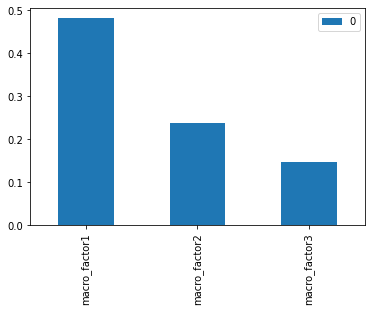

In [ ]:
explained_variance_df = pd.DataFrame(data=pca.explained_variance_ratio_, index=macro_pca_df.columns)
explained_variance_df.plot(kind='bar')

#### Checking component to check the property of newly created fewer factors.

By checking components_, we can check the factor properties of reduced factors.

In [ ]:
components_df = pd.DataFrame(data=pca.components_, index= macro_pca_df.columns,
                             columns = normalized_df.columns)

For example... 
- macro_factor1: high absolute component values in NASDAQ, T10y2Y, Gold, and VIX. macro_factor1 summarizes information regarding overall equity and interest rate sentiment.
- macro_factor2: high absolute component values in DGS10, BAA10Y. We can guess that macro_factor2 is related with the 10 year interest rate in government bond and corporate bond.
- macro_factor3: high absolute values in TEDRATE, BAA10Y, WTI oil price. This factor summarizes information regarding credit market and commodity price situation.

In [ ]:
components_df

,NASDAQCOM,DGS10,TEDRATE,T10Y2Y,BAA10Y,DCOILWTICO,GOLDAMGBD228NLBM,VIXCLS
macro_factor1,0.414604,0.091758,0.318255,-0.519893,0.305741,-0.127963,-0.427345,-0.394503
macro_factor2,-0.227992,-0.621943,-0.104006,-0.044624,0.637159,-0.253224,-0.090628,0.264746
macro_factor3,0.320320,-0.032270,-0.446223,0.173349,0.420677,0.584643,0.193867,-0.332909


#### Correlation among reduced factors

Great point of PCA is that reduced factors are orthogonal i.e. having zero correlation each other. It can avoid several statistical problem in data analysis, such as multicoliniarlity.

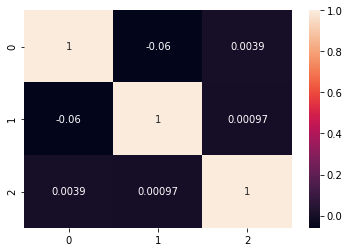

In [ ]:
sns.heatmap(np.corrcoef(hist_pca_df, rowvar=False), annot=True)